# Basic example

Let us start by importing `numpy` and `pyshqg`.
Note that in `pyshqg` we only import:

- the constructors `construct_model()` and `construct_integrator()`;
- the auxiliary function `load_test_data()`.

In [1]:
import numpy as np
from pyshqg.core_numpy.constructors import construct_model, construct_integrator
from pyshqg.preprocessing.reference_data import load_test_data

## Unit test

Let us define a function to compute the relative root mean squared error (RMSE)
between two vectors.

In [2]:
def relative_rmse(x, y):
    rms_x = np.sqrt(np.mean(np.square(x)))
    rms_y = np.sqrt(np.mean(np.square(y)))
    rms_xy = np.sqrt(np.mean(np.square(x-y)))
    return rms_xy, rms_x, rms_y, 2*rms_xy/(rms_x+rms_y)

We now load the test data at T21 resolution, interpolated in the T31 Gauss--Legendre grid.

In [3]:
ds_test = load_test_data(
    internal_truncature=21,
    grid_truncature=31,
)

`ds_test` is now an `xarray.Dataset` containing the required test data as data variables.

In [4]:
ds_test

<xarray.Dataset>
Dimensions:             (ensemble: 16, level: 3, lat: 32, lon: 64, c: 2, l: 22,
                         m: 22)
Coordinates:
  * lat                 (lat) float64 85.76 80.27 74.74 ... -74.74 -80.27 -85.76
  * lon                 (lon) float64 0.0 5.625 11.25 ... 343.1 348.8 354.4
Dimensions without coordinates: ensemble, level, c, l, m
Data variables: (12/21)
    dissip_ekman        (ensemble, level, lat, lon) float64 0.0 ... -1.265e-11
    dpsi_dphi           (ensemble, level, lat, lon) float64 -0.1937 ... -0.2856
    dpsi_dtheta         (ensemble, level, lat, lon) float64 -0.02461 ... 0.3131
    dq_dphi             (ensemble, level, lat, lon) float64 1.216e-12 ... -2....
    dq_dtheta           (ensemble, level, lat, lon) float64 -1.245e-13 ... 4....
    forcing             (level, lat, lon) float64 -7e-11 ... -1.593e-10
    ...                  ...
    spec_q              (ensemble, level, c, l, m) float64 -5.365e-07 ... -7....
    spec_rk2            (ensemble, level, c, l, m) float64 -5.364e-07 ... -7....
    spec_rk4            (ensemble, level, c, l, m) float64 -5.364e-07 ... -7....
    spec_tendencies     (ensemble, level, c, l, m) float64 2.901e-16 ... -2.3...
    spec_total_q        (ensemble, level, c, l, m) float64 -5.365e-07 ... -3....
    zeta                (ensemble, lat, lon) float64 3.467e-06 ... -2.833e-06
Attributes:
    config:   {'abm_integration': {'dt': 1800, 'method': 'abm'}, 'data_interp...

Next, we create a model using the configuration encapsulated in the test data attribute `config`,
and a fourth-order Runge--Kutta integrator using once again the configuration.

In [5]:
model = construct_model(ds_test.config)
rk4 = construct_integrator(ds_test.config['rk4_integration'], model)

Finally, we create a model state using variable `spec_q` of `ds_test`, which contains the vorticity in spectral space.

In [6]:
state = model.model_state(ds_test.spec_q.to_numpy())

`state` is now a dictionnary, containing only the spectral vorticity at key `"spec_q"`.

In [7]:
print(type(state))
print(state.keys())

<class 'dict'>
dict_keys(['spec_q'])


The spectral vorticity is a numpy array of shape `(Ne, Nz, 2, T+1, T+1)` where

- `Ne` is the ensemble size;
- `Nz=3` is the number of vertical levels;
- `(2, T+1, T+1)` correspond to the spectral coefficients.

In [8]:
print(type(state['spec_q']))
print(state['spec_q'].shape)

<class 'numpy.ndarray'>
(16, 3, 2, 22, 22)


It is now time to run one integration step, using the `forward()` method of the integrator.

In [9]:
fwd_state = rk4.forward(state)

We compare the obtained integrated state to the test data using the relative RMSE.
The result is lower than $10^{-9}$, hence we conclude that our integration should
be correct.

In [10]:
relative_rmse(
    fwd_state['spec_q'],
    ds_test.spec_rk4.to_numpy(),
)

(7.463234256549668e-16,
 4.2354746605770695e-06,
 4.235474660384873e-06,
 1.7620774186622474e-10)

## Example model integration

Next, we use the model integrator to compute a full trajectory, using the `run()` method of the integrator,
where we need to specify:

- the starting time (in model time unit) (`t_start`);
- the number of snapshots to compute (`num_snapshots`);
- the number of integration steps between two snapshots (`num_steps_per_snapshot`);
- the list of variables to record (`variables`).

In [11]:
state = model.model_state(ds_test.spec_q.to_numpy())
trajectory = rk4.run(
    state,
    t_start=0,
    num_snapshots=8,
    num_steps_per_snapshot=10,
    variables=('spec_q', 'spec_psi', 'zeta', 'q', 'psi'),
)

model integration:   0%|          | 0/8 [00:00<?, ?it/s]

The result is a `pyshqg.core_numpy.model.QGModelTrajectory` instance.

In [12]:
print(type(trajectory))

<class 'pyshqg.core_numpy.model.QGModelTrajectory'>


This object can be converted into a dictionnary of numpy arrays
or directly into an `xarray.Dataset` as follows:

In [13]:
trajectory_xr = trajectory.to_xarray()
trajectory_xr

<xarray.Dataset>
Dimensions:   (time: 9, batch_0: 16, level: 3, c: 2, l: 22, m: 22, lat: 32,
               lon: 64)
Coordinates:
  * time      (time) int64 0 18000 36000 54000 72000 90000 108000 126000 144000
  * lat       (lat) float64 -85.76 -80.27 -74.74 -69.21 ... 74.74 80.27 85.76
  * lon       (lon) float64 180.0 185.6 191.2 196.9 ... 157.5 163.1 168.8 174.4
Dimensions without coordinates: batch_0, level, c, l, m
Data variables:
    spec_q    (time, batch_0, level, c, l, m) float64 -5.365e-07 ... -1.223e-08
    spec_psi  (time, batch_0, level, c, l, m) float64 0.0 0.0 ... 285.9 322.0
    zeta      (time, batch_0, lat, lon) float64 3.467e-06 ... -1.455e-05
    q         (time, batch_0, level, lat, lon) float64 -0.000298 ... -0.0001269
    psi       (time, batch_0, level, lat, lon) float64 1.445e+08 ... -1.38e+07

## Plot the result

Finally, let us plot the stream function $\psi$ at the end of the simulation (`time=-1`) 
for the first ensemble ensemble member (`batch_0=0`). We show only the lowest level (`level=-1`).

Note that the plot is drawn using `matplotlib`. We use `cartopy` to map the latitude-longitude
coordinates into the figure for a given projection (`ccrs.Robinson` here). Also note that we use
one of the perceptually uniform colormap from the package `cmocean`.

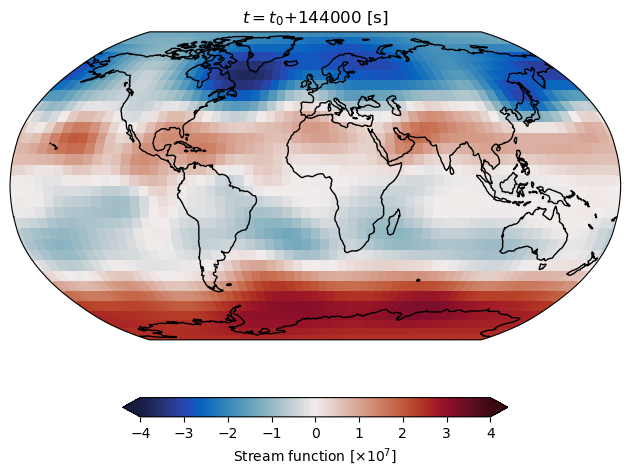

In [14]:
# TODO: include unit for the stream function
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection=ccrs.Robinson())

lon = trajectory_xr.lon.to_numpy()
lat = trajectory_xr.lat.to_numpy()
psi = trajectory_xr.psi.isel(time=-1, batch_0=0, level=-1).to_numpy() / 1e7
time = trajectory_xr.time.to_numpy()[-1]

ax.set_title(f'$t=t_0$+{time} [s]')
im = ax.pcolormesh(
    lon,
    lat,
    psi,
    cmap=cmocean.cm.balance,
    vmin=-4,
    vmax=4,
    transform=ccrs.PlateCarree(),
)
ax.coastlines()
plt.colorbar(
    im,
    orientation='horizontal',
    extend='both',
    fraction=0.05,
    shrink=0.75,
    label='Stream function [$\\times 10^{7}$]',
)
plt.show()